In [1]:
#Standard

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE

import tensorflow as tf
from tensorflow import keras

#Keras
import sysidentpy
from torch import nn

#others
from tqdm.notebook import tqdm
import itertools

In [2]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.model_structure_selection import AOLS

from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.metrics import r2_score,max_error, mean_absolute_error, mean_squared_error

In [3]:
from os import mkdir
from datetime import datetime
import time

In [4]:
from sysidentpy.neural_network import NARXNN
print(sysidentpy.__version__)

0.2.0


In [5]:
def inputs_selection(key, target = 'Pressure'):
     
    if target == 'Pressure':
    
        inputs_dict = {
            1:'AVG_DOWNHOLE_PRESSURE',
            2:'AVG_DOWNHOLE_TEMPERATURE',
            3:'BORE_OIL_VOL', #paper used wellhead pressure
            4:'BORE_GAS_VOL',
            5:'BORE_WAT_VOL',
            6:'AVG_CHOKE_SIZE_P',
            7:'ON_STREAM_HRS'
        }
        
    else:
        
        inputs_dict = {
            1:'CUMALATIVE_TIME',
            2:'AVG_DOWNHOLE_TEMPERATURE',
            3:'AVG_DOWNHOLE_PRESSURE', #paper used wellhead pressure
            4:'AVG_CHOKE_SIZE_P',
            5:'AVG_RS',
            6:'AVG_DP_TUBING',
            7:'DP_CHOKE_SIZE',
            8:'BORE_OIL_VOL',
            9:'BORE_GAS_VOL',
            10:'BORE_WAT_VOL'}

    inputs = []
    
    for i in key:
        inputs.append(inputs_dict[i])    
    return inputs

In [6]:
def create_train_test(data, columns, test_size = 0.2):

    train_index = int(data.shape[0]*(1-test_size))
    train_data = df.iloc[:train_index,:]
    test_data = df.iloc[train_index:,:]

    print('TARGET SELECTED = ', inputs_selection([1]))
    
    print('FEATURES SELECTED = ', inputs_selection(columns))
    
    train_X, test_X = train_data.loc[:,inputs_selection(columns)], test_data.loc[:,inputs_selection(columns)]
    train_y, test_y = train_data.loc[:,inputs_selection([1])], test_data.loc[:,inputs_selection([1])]
    
    return np.array(train_X), np.array(test_X), np.array(train_y), np.array(test_y)

In [7]:
def model_train_results(model, train_X, train_y, test_X, test_y):
    
    model.fit(X=train_X, y=train_y)
    
    yhat = model.predict(X=test_X, y=test_y)

    rrse = root_relative_squared_error(test_y, yhat)
    print('RRSE: ',rrse)
    print('R2: ',round(r2_score(test_y, yhat),5))
    
    plot_results(y=test_y, yhat = yhat)
    
    ee = compute_residues_autocorrelation(test_y, yhat)
    plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
    x1e = compute_cross_correlation(test_y, yhat, test_X)
    plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")
    
    return model
    
'''
results_ = pd.DataFrame(
results(
    model.final_model, model.theta, model.err,
    model.n_terms, err_precision=8, dtype='sci'
    ),
columns=['Regressors', 'Parameters', 'ERR'])
print(results_)
'''

"\nresults_ = pd.DataFrame(\nresults(\n    model.final_model, model.theta, model.err,\n    model.n_terms, err_precision=8, dtype='sci'\n    ),\ncolumns=['Regressors', 'Parameters', 'ERR'])\nprint(results_)\n"

In [8]:
#df = pd.read_csv('Volve_NO15-9-F-14H.csv', sep =';', decimal = ',' )

df = pd.read_csv('Volve_production_data.csv', sep =';', decimal = ',' )

#df['AVG_RS'] = pd.to_numeric(df['RS'],errors = 'coerce')
columns_df = list(df)

filtro = df.AVG_DOWNHOLE_PRESSURE == 0
df = df.loc[df.AVG_DOWNHOLE_PRESSURE > 0]

CUMALATIVE_TIME = np.arange(1,df.shape[0]+1)
df.insert(1,'CUMALATIVE_TIME', CUMALATIVE_TIME)

#df.AVG_CHOKE_SIZE_P = df.AVG_CHOKE_SIZE_P.fillna(0)
#display(df.isnull().sum())

filtro = df.WELL_BORE_CODE == 'NO 15/9-F-1 C'
df = df.loc[filtro]

data = pd.DataFrame()
columns = ['AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE','BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'AVG_CHOKE_SIZE_P','ON_STREAM_HRS']
for element in columns:
    data[element] = df[element].astype(float)
    
display(data)

df = data

08-20 12:05:05 - INFO - NumExpr defaulting to 6 threads.


,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,AVG_CHOKE_SIZE_P,ON_STREAM_HRS
4,310.376,96.876,0.0,0.0,0.0,1.21599,0.0
5,303.501,96.923,0.0,0.0,0.0,3.08702,0.0
6,303.535,96.959,0.0,0.0,0.0,1.96237,0.0
7,303.782,96.969,0.0,0.0,0.0,0.00000,0.0
8,303.858,97.021,0.0,0.0,0.0,31.14186,0.0
...,...,...,...,...,...,...,...
740,266.148,101.170,0.0,0.0,0.0,0.00000,0.0
741,270.268,101.198,0.0,0.0,0.0,0.00000,0.0
742,276.869,101.231,0.0,0.0,0.0,0.00000,0.0
743,282.105,101.178,0.0,0.0,0.0,0.26519,0.0


#####################################################################
FEATURES SELECTED =  ['AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/2 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     5
RMSE:  0.3651947010350444
R2:  0.90662
#####################################################################
 Order Selected:     15
RMSE:  0.29755404649685674
R2:  0.92244


,Order,RMSE,R2,Best
0,5,0.365195,0.906619,False
1,15,0.297554,0.922437,True


0.9224373274334071 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001FC1FAE7250> 15
   Regressors   Parameters             ERR
0      y(k-1)   9.9310E-01  9.99464631E-01
1      y(k-2)  -1.3133E-01  1.00881450E-04
2    x1(k-15)   3.9789E-02  3.20404051E-05
3     x1(k-1)  -2.1128E-01  9.38243140E-06
4           1   3.7921E+01  3.59507354E-05
5     x1(k-2)   1.3972E-01  7.87779217E-06
6     x1(k-3)  -8.5086E-02  9.61915689E-06
7     y(k-10)   8.4709E-02  2.14789071E-06
8     x1(k-6)  -4.6074E-02  2.14433761E-06
9      y(k-6)  -7.4793E-02  9.15762910E-07
10    y(k-15)   1.1222E-01  5.43135533E-07
11    y(k-14)  -1.2214E-01  2.65058211E-06
12   x1(k-14)  -2.1932E-02  5.92700482E-07
13     y(k-7)   5.1450E-02  2.80096759E-07
14     y(k-9)  -4.5015E-02  4.37187947E-07


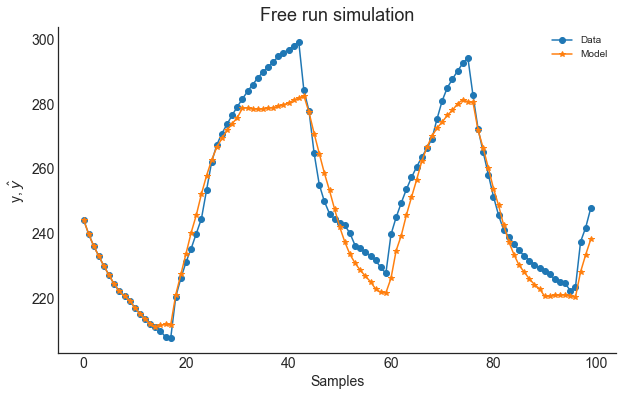

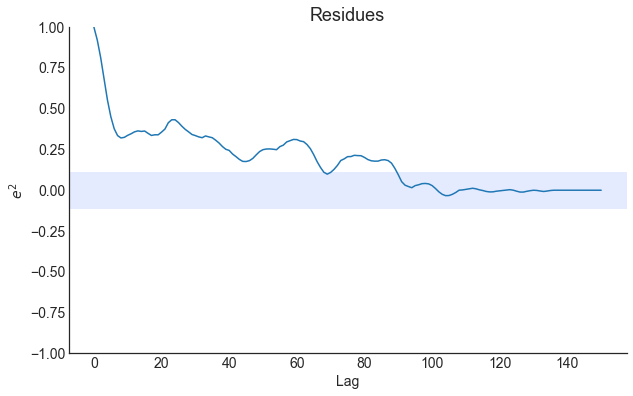

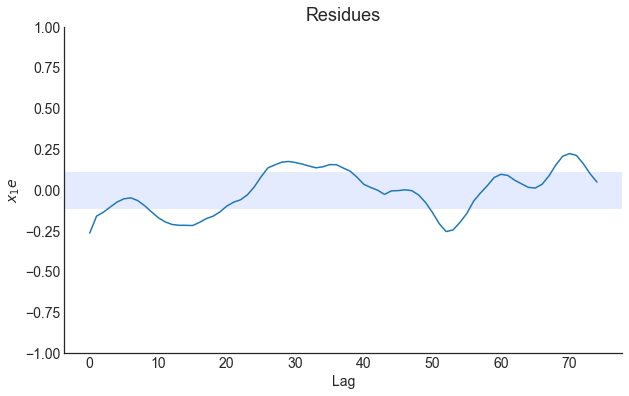

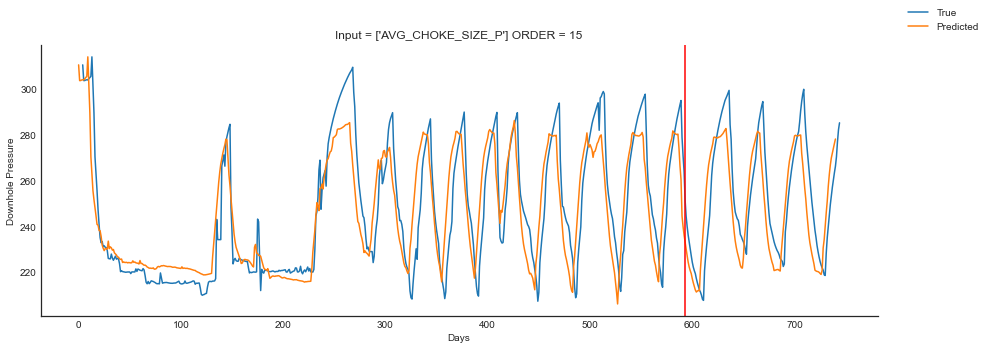

In [9]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [5,15]

# Teste apenas do 6:'AVG_CHOKE_SIZE_P'

feature = 6
    
r2_best = 0
history = []
results_ = pd.DataFrame()

X_inputs = inputs_selection([feature])
#best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']

train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
print('#####################################################################')
print('FEATURES SELECTED = ', inputs_selection([feature]))
print('#####################################################################')

for order in tqdm(n_order):

    print('#####################################################################')
    print(' Order Selected:    ',order)                


    basis_function = Polynomial(degree=1)

    lag = list(range(1,order+1))
    
    model = FROLS(
        order_selection=True,
        n_terms=order,
        extended_least_squares=False,
        ylag=order, xlag=order,
        info_criteria='bic',
        estimator='least_squares',
        basis_function=basis_function
    )

    model.fit(X = train_X, y = train_y)

    yhat = model.predict(X=test_X, y=test_y)

    try:
        r2 = r2_score(test_y, yhat)
        rrse = root_relative_squared_error(test_y, yhat)
    except:
        print('MODEL FAILED')
        r2 = 0
        rrse = 0
        pass

    print('RMSE: ',rrse)
    print('R2: ',round(r2,5))


    history.append([order,rrse,r2])

    if r2 > r2_best:      
        r2_best = r2
        best_model = model
        best_order = order

History = pd.DataFrame(history, columns = ['Order','RMSE','R2'])
History['Best'] = (History['R2'] == r2_best)

display(History)

print(r2_best,best_model,best_order)

yhat = best_model.predict(X=test_X, y=test_y)


results_ = pd.DataFrame(
    results(
        model.final_model, best_model.theta, best_model.err,
        best_model.n_terms, err_precision=8, dtype='sci'),
    columns=['Regressors', 'Parameters', 'ERR'])
print(results_)

plot_results(y=test_y, yhat = yhat)

ee = compute_residues_autocorrelation(test_y, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

results_sysid = []
results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

fig,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
ax1.plot(results_sysid, label = 'Predicted')
ax1.axvline(x=train_index,color = 'r')
ax1.set_title(f'Input = {inputs_selection([feature])} ORDER = {best_order}',)
ax1.set_ylabel('Downhole Pressure')
ax1.set_xlabel('Days')

fig.legend( loc = 'upper right')
plt.show()


### Improviment try

In [10]:
def matReg(y,u,ny,nu):
    # for debuging code
    # y= np.array([1, 2, 3,4,5,6,7,8,9,10])
    # u= np.array([1, 2, 3,4,5,6,7,8,9,10])

    p = np.max((ny,nu)) + 1
    (N, ) = y.reshape(-1,).shape
    (Nu, ) = u.reshape(-1,).shape
    
    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)
    
    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)


def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1 
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        if k % 50 == 0:
            print(k)
        
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)
        
        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(fr_input)
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):] 

def norm01(u,minu,maxu):
    return (u-minu)/(maxu-minu)



In [11]:
ue = train_X.reshape(-1,)
ye = best_model.predict(X=train_X, y=train_y) - train_y
ye = ye.reshape(-1,)

ut = test_X.reshape(-1,)
yt = best_model.predict(X=test_X, y=test_y) - test_y
yt = yt.reshape(-1,)

# normalize inputs
# maxu = np.amax([ue.__abs__().max(),ut1.__abs__().max(),ut2.__abs__().max()])
maxu = np.amax([ue.max(),ut.max()])
minu = np.amin([ue.min(),ut.min()])
maxy = np.amax([ye.max(),yt.max()])
miny = np.amin([ye.min(),yt.min()])

#ue,ut= norm01(ue,minu,maxu).reshape(-1,),norm01(ut,minu,maxu).reshape(-1,)
#ye,yt = norm01(ye,miny,maxy).reshape(-1,),norm01(yt,miny,maxy).reshape(-1,)



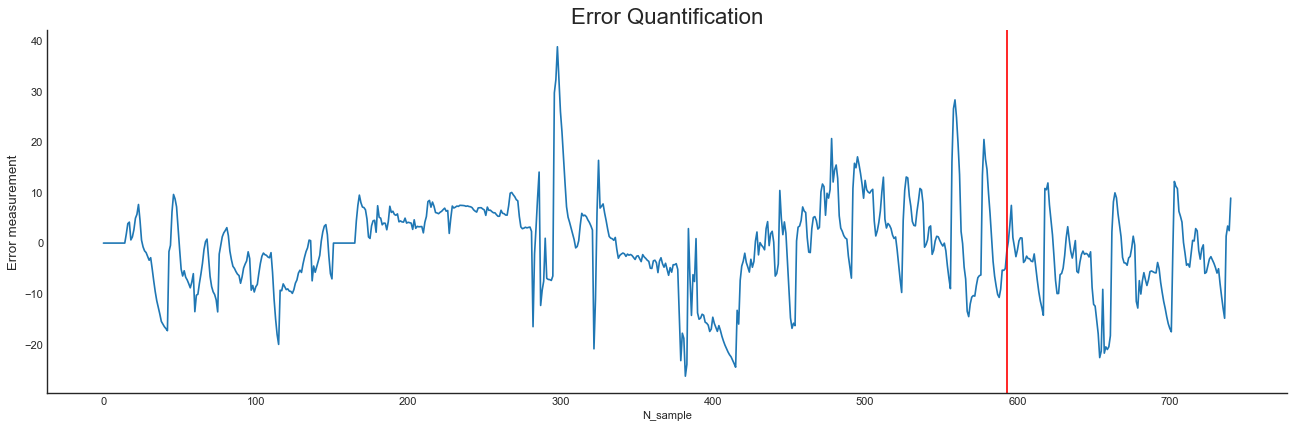

In [12]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(np.concatenate([yt,ye]))
plt.title('Error Quantification', fontsize = 20)
plt.xlabel('N_sample')
plt.ylabel('Error measurement', fontsize = 12)
plt.axvline(x=train_index,color = 'r')

ny = 15
nu = 15 # model orders
(Ye,Phie) = matReg(ye,ue,ny,nu)
(Yt,Phit) = matReg(yt,ut,ny,nu)

# definicao da arquitetura
_ , ninp = Phie.shape
nout = 1
nneu = 70 # how many neurons per layer

# multiple runs setup
nsim = 5
now = datetime.now()
uniqueStr = now.strftime("test_%Y%m%d_%Hh%Mm%Ss")
mkdir(uniqueStr)
MATR2 = np.zeros((nsim,4)) # 4: 4 tipos de R2

In [13]:
t0= time.perf_counter()
for k in range(nsim):
    # model definition
    input_ = keras.layers.Input(shape=(ninp,))
    hidden1 = keras.layers.Dense(nneu, activation="tanh",kernel_initializer="GlorotNormal",)(input_)
    hidden2 = keras.layers.Dense(nneu, activation="tanh",kernel_initializer="GlorotNormal")(hidden1)
    dropout1 = keras.layers.Dropout(0.2)(hidden2)
    hidden3 = keras.layers.Dense(nneu, activation="tanh",kernel_initializer="GlorotNormal")(dropout1)
    dropout2 = keras.layers.Dropout(0.2)(hidden3)
    output = keras.layers.Dense(nout)(dropout2)

    # instantiate model
    model = keras.models.Model(inputs=[input_],outputs=[output])

    # define optimizer and learning rate
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
    
    #Define EarlyStopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=16)

    # compile model to train it
    model.compile(loss="mean_squared_error", optimizer=optimizer)

    # history = model.fit(Phie, Ye, epochs=10, batch_size = 8)
    history = model.fit(Phie, Ye, epochs=128, batch_size = 32, validation_split=0.15, callbacks=[callback])

    # One step ahead
    y_train_pred1 = model.predict(Phie)
    y_test_pred1  = model.predict(Phit)
    R2test1  = r2_score(Yt, y_test_pred1)
    R2train1 = r2_score(Ye, y_train_pred1)

    # Free Run
    y_train_pred0 = freeRun(model,ye,ue,ny,nu)
    y_test_pred0  = freeRun(model,yt,ut,ny,nu)
    R2train0 = r2_score(Ye, y_train_pred0)
    R2test0  = r2_score(Yt, y_test_pred0)

    print('-------------- One step ahead  --------------')
    print('R2test1  =')
    print(R2test1)
    print('R2train1  =')
    print(R2train1)

    print('-------------- Free Run  --------------')
    print('R2test0  =')
    print(R2test0)
    print('R2train0  =')
    print(R2train0)
    # b = [0, -1, 3, 8, 9]
    # plt.figure()
    # plt.plot(b,'k')
    # plt.savefig("plot_1_test_%1d.png" %(k))
    # plt.show()
    # plt.close()

    # plots (time)
    # ESTIMATION 
    plt.figure()
    plt.subplot(211)
    plt.plot(Ye,'k',y_train_pred1,'r')
    plt.title('OSA')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.subplot(212)
    plt.plot(Ye,'k',y_train_pred0,'r')
    plt.title('FR')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.savefig(uniqueStr + "/test_%1d_plot_1.png" %(k))
    # plt.show()
    plt.close()
    
    # VALIDATION 
    plt.figure()
    plt.subplot(211)
    plt.plot(Yt,'k',y_test_pred1,'r')
    plt.title('OSA')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.subplot(212)
    plt.plot(Yt,'k',y_test_pred0,'r')
    plt.title('FR')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.savefig(uniqueStr + "/test_%1d_plot_2.png" %(k))
    # plt.show()
    plt.close()

    plt.figure()
    minY = min(min(Ye),min(y_train_pred0))
    maxY = max(max(Ye),max(y_train_pred0))
    plt.subplot(1,2,1)
    plt.scatter(Ye,y_train_pred0,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Estimation FR')
    plt.grid()
    plt.legend()

    minY = min(min(Ye),min(y_train_pred1))
    maxY = max(max(Ye),max(y_train_pred1))
    plt.subplot(1,2,2)
    plt.scatter(Ye,y_train_pred1,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Estimation OSA')
    plt.grid()
    plt.legend()
    plt.savefig(uniqueStr + "/test_%1d_plot_3.png" %(k))
    # plt.show()
    plt.close()

    plt.figure()
    minY = min(min(Yt),min(y_test_pred1))
    maxY = max(max(Yt),max(y_test_pred1))
    plt.subplot(1,2,1)
    plt.scatter(Yt,y_test_pred1,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Validation OSA')
    plt.grid()
    plt.legend()
    
    minY = min(min(Yt),min(y_test_pred0))
    maxY = max(max(Yt),max(y_test_pred0))
    plt.subplot(1,2,2)
    plt.scatter(Yt,y_test_pred0,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Validation FR')
    plt.grid()
    plt.legend()
    plt.savefig(uniqueStr + "/test_%1d_plot_4.png" %(k))
    # plt.show()
    plt.close()

    # save R2 values
    MATR2[k,] = np.array((R2train1,R2train0,R2test1,R2test0))
    
tMin = (time.perf_counter() - t0)/60
np.savetxt(uniqueStr + "/R2_elapsedTime_%1.4fmin.txt" %tMin, MATR2, fmt='%1.6f')

Epoch 1/128
16/16 [==============================] - 1s 17ms/step - loss: 75.4412 - val_loss: 63.4425
Epoch 2/128
16/16 [==============================] - 0s 4ms/step - loss: 58.2293 - val_loss: 44.4878
Epoch 3/128
16/16 [==============================] - 0s 4ms/step - loss: 48.0131 - val_loss: 37.6839
Epoch 4/128
16/16 [==============================] - 0s 4ms/step - loss: 40.3076 - val_loss: 36.3207
Epoch 5/128
16/16 [==============================] - 0s 4ms/step - loss: 35.6228 - val_loss: 35.7724
Epoch 6/128
16/16 [==============================] - 0s 4ms/step - loss: 31.5970 - val_loss: 33.5206
Epoch 7/128
16/16 [==============================] - 0s 4ms/step - loss: 29.4456 - val_loss: 33.1859
Epoch 8/128
16/16 [==============================] - 0s 3ms/step - loss: 27.6313 - val_loss: 34.7819
Epoch 9/128
16/16 [==============================] - 0s 4ms/step - loss: 25.6659 - val_loss: 35.2891
Epoch 10/128
16/16 [==============================] - 0s 4ms/step - loss: 25.2141 - val_lo

16/16 [==============================] - 0s 3ms/step - loss: 6.6410 - val_loss: 48.1886
Epoch 82/128
16/16 [==============================] - 0s 3ms/step - loss: 6.7580 - val_loss: 49.3274
Epoch 83/128
16/16 [==============================] - 0s 4ms/step - loss: 7.4325 - val_loss: 47.3006
Epoch 84/128
16/16 [==============================] - 0s 4ms/step - loss: 7.1068 - val_loss: 47.5958
Epoch 85/128
16/16 [==============================] - 0s 4ms/step - loss: 7.1267 - val_loss: 50.3569
Epoch 86/128
16/16 [==============================] - 0s 3ms/step - loss: 7.1661 - val_loss: 53.6232
Epoch 87/128
16/16 [==============================] - 0s 4ms/step - loss: 7.7451 - val_loss: 46.4903
Epoch 88/128
16/16 [==============================] - 0s 4ms/step - loss: 7.8094 - val_loss: 49.3296
Epoch 89/128
16/16 [==============================] - 0s 4ms/step - loss: 7.7308 - val_loss: 47.8233
Epoch 90/128
16/16 [==============================] - 0s 3ms/step - loss: 7.6427 - val_loss: 51.6065
Epo

16/16 [==============================] - 0s 4ms/step - loss: 13.9608 - val_loss: 37.1710
Epoch 32/128
16/16 [==============================] - 0s 3ms/step - loss: 13.1038 - val_loss: 38.0606
Epoch 33/128
16/16 [==============================] - 0s 3ms/step - loss: 12.9208 - val_loss: 35.9300
Epoch 34/128
16/16 [==============================] - 0s 3ms/step - loss: 12.1940 - val_loss: 37.8758
Epoch 35/128
16/16 [==============================] - 0s 3ms/step - loss: 11.6538 - val_loss: 37.3591
Epoch 36/128
16/16 [==============================] - 0s 3ms/step - loss: 12.6349 - val_loss: 36.1374
Epoch 37/128
16/16 [==============================] - 0s 3ms/step - loss: 11.8107 - val_loss: 37.6695
Epoch 38/128
16/16 [==============================] - 0s 3ms/step - loss: 11.7908 - val_loss: 38.3097
Epoch 39/128
16/16 [==============================] - 0s 3ms/step - loss: 11.9589 - val_loss: 39.0793
Epoch 40/128
16/16 [==============================] - 0s 4ms/step - loss: 11.2706 - val_loss: 3

Epoch 112/128
16/16 [==============================] - 0s 3ms/step - loss: 8.4160 - val_loss: 45.3015
Epoch 113/128
16/16 [==============================] - 0s 4ms/step - loss: 7.9068 - val_loss: 41.9758
Epoch 114/128
16/16 [==============================] - 0s 3ms/step - loss: 7.1932 - val_loss: 40.7085
Epoch 115/128
16/16 [==============================] - 0s 4ms/step - loss: 6.7248 - val_loss: 41.4050
Epoch 116/128
16/16 [==============================] - 0s 3ms/step - loss: 6.8378 - val_loss: 42.7926
Epoch 117/128
16/16 [==============================] - 0s 3ms/step - loss: 6.3223 - val_loss: 40.9127
Epoch 118/128
16/16 [==============================] - 0s 4ms/step - loss: 5.8084 - val_loss: 39.9782
Epoch 119/128
16/16 [==============================] - 0s 4ms/step - loss: 6.9481 - val_loss: 38.3150
Epoch 120/128
16/16 [==============================] - 0s 3ms/step - loss: 6.4674 - val_loss: 40.9268
Epoch 121/128
16/16 [==============================] - 0s 3ms/step - loss: 7.0378 

16/16 [==============================] - 0s 4ms/step - loss: 8.1880 - val_loss: 50.2206
Epoch 63/128
16/16 [==============================] - 0s 4ms/step - loss: 7.7629 - val_loss: 49.1505
Epoch 64/128
16/16 [==============================] - 0s 3ms/step - loss: 7.6311 - val_loss: 47.5882
Epoch 65/128
16/16 [==============================] - 0s 4ms/step - loss: 7.1426 - val_loss: 50.9920
Epoch 66/128
16/16 [==============================] - 0s 3ms/step - loss: 7.7266 - val_loss: 49.1116
Epoch 67/128
16/16 [==============================] - 0s 4ms/step - loss: 7.2149 - val_loss: 46.9526
Epoch 68/128
16/16 [==============================] - 0s 4ms/step - loss: 7.4615 - val_loss: 46.6132
Epoch 69/128
16/16 [==============================] - 0s 4ms/step - loss: 7.2215 - val_loss: 51.0770
Epoch 70/128
16/16 [==============================] - 0s 4ms/step - loss: 8.1585 - val_loss: 49.6143
Epoch 71/128
16/16 [==============================] - 0s 4ms/step - loss: 7.9521 - val_loss: 47.2067
Epo

C:\Users\danie\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Epoch 1/128
16/16 [==============================] - 1s 13ms/step - loss: 77.6489 - val_loss: 64.8180
Epoch 2/128
16/16 [==============================] - 0s 5ms/step - loss: 61.7307 - val_loss: 48.1123
Epoch 3/128
16/16 [==============================] - 0s 5ms/step - loss: 50.8876 - val_loss: 39.6068
Epoch 4/128
16/16 [==============================] - 0s 5ms/step - loss: 42.7593 - val_loss: 35.5748
Epoch 5/128
16/16 [==============================] - 0s 5ms/step - loss: 38.4062 - val_loss: 33.1774
Epoch 6/128
16/16 [==============================] - 0s 5ms/step - loss: 35.1285 - val_loss: 35.7189
Epoch 7/128
16/16 [==============================] - 0s 5ms/step - loss: 32.7378 - val_loss: 31.9511
Epoch 8/128
16/16 [==============================] - 0s 4ms/step - loss: 29.7278 - val_loss: 31.0889
Epoch 9/128
16/16 [==============================] - 0s 5ms/step - loss: 28.0855 - val_loss: 32.8945
Epoch 10/128
16/16 [==============================] - 0s 5ms/step - loss: 25.7596 - val_lo

16/16 [==============================] - 0s 4ms/step - loss: 7.8240 - val_loss: 34.5487
Epoch 82/128
16/16 [==============================] - 0s 4ms/step - loss: 7.7147 - val_loss: 35.6506
Epoch 83/128
16/16 [==============================] - 0s 4ms/step - loss: 8.0236 - val_loss: 33.9961
Epoch 84/128
16/16 [==============================] - 0s 4ms/step - loss: 7.5172 - val_loss: 33.1571
Epoch 85/128
16/16 [==============================] - 0s 4ms/step - loss: 7.5317 - val_loss: 32.7193
Epoch 86/128
16/16 [==============================] - 0s 4ms/step - loss: 7.2419 - val_loss: 36.3925
Epoch 87/128
16/16 [==============================] - 0s 4ms/step - loss: 7.5481 - val_loss: 34.5774
Epoch 88/128
16/16 [==============================] - 0s 4ms/step - loss: 6.9446 - val_loss: 34.3781
Epoch 89/128
16/16 [==============================] - 0s 7ms/step - loss: 7.7341 - val_loss: 38.9933
Epoch 90/128
16/16 [==============================] - 0s 4ms/step - loss: 7.2244 - val_loss: 37.0716
Epo

Epoch 31/128
16/16 [==============================] - 0s 4ms/step - loss: 12.6476 - val_loss: 31.7102
Epoch 32/128
16/16 [==============================] - 0s 4ms/step - loss: 11.6435 - val_loss: 32.9697
Epoch 33/128
16/16 [==============================] - 0s 4ms/step - loss: 11.3346 - val_loss: 33.6435
Epoch 34/128
16/16 [==============================] - 0s 3ms/step - loss: 10.2201 - val_loss: 34.4879
Epoch 35/128
16/16 [==============================] - 0s 4ms/step - loss: 11.4057 - val_loss: 32.2620
Epoch 36/128
16/16 [==============================] - 0s 4ms/step - loss: 9.9834 - val_loss: 33.1935
Epoch 37/128
16/16 [==============================] - 0s 4ms/step - loss: 11.0179 - val_loss: 32.3444
Epoch 38/128
16/16 [==============================] - 0s 4ms/step - loss: 10.7710 - val_loss: 32.3045
Epoch 39/128
16/16 [==============================] - 0s 4ms/step - loss: 10.5753 - val_loss: 30.8197
Epoch 40/128
16/16 [==============================] - 0s 3ms/step - loss: 11.2367 -

## NARX

#####################################################################
FEATURES SELECTED =  ['AVG_CHOKE_SIZE_P']
#####################################################################


  0%|          | 0/2 [00:00<?, ?it/s]

#####################################################################
 Order Selected:     5
RMSE:  0.3053680969759038
R2:  0.92628
#####################################################################
 Order Selected:     15
RMSE:  0.30676329316351497
R2:  0.9074


,Order,RMSE,R2,Best
0,5,0.305368,0.926282,True
1,15,0.306763,0.907399,False


0.92628217560439 <sysidentpy.model_structure_selection.forward_regression_orthogonal_least_squares.FROLS object at 0x000001FC2E5377F0> 5
      Regressors   Parameters             ERR
0         y(k-1)   1.0175E+00  9.99454016E-01
1   y(k-8)y(k-3)   1.2033E-01  1.05713822E-04
2  x1(k-1)y(k-2)   5.6228E-04  3.01848790E-05
3   y(k-2)y(k-1)  -6.3938E-04  1.20264806E-05
4      x1(k-2)^2  -1.0445E-03  3.66255907E-05


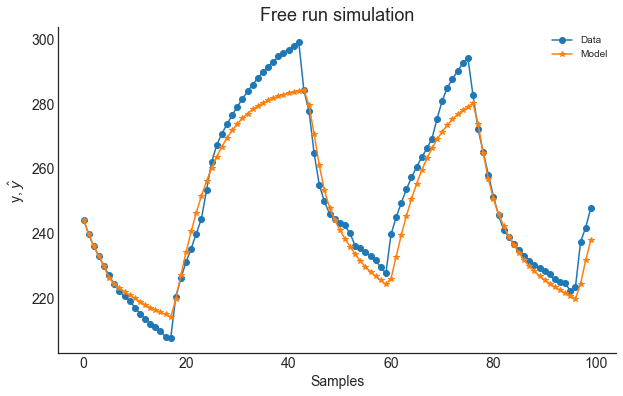

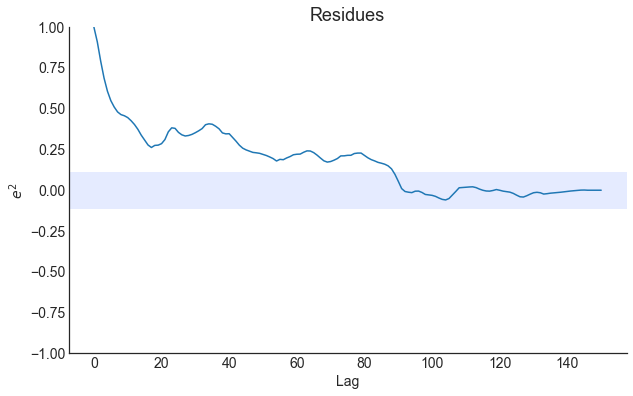

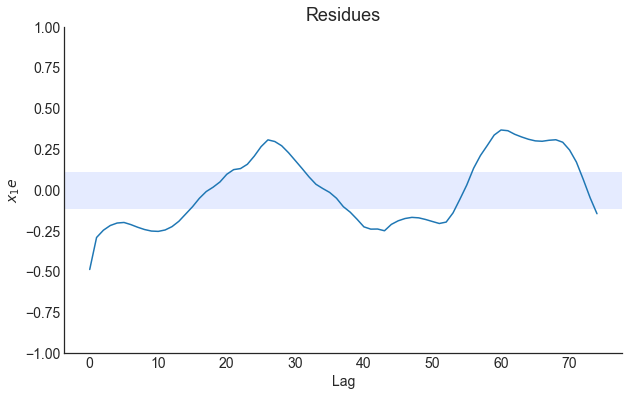

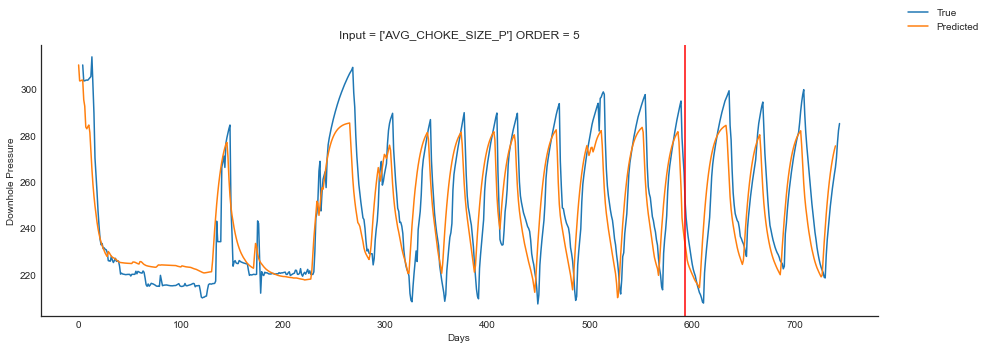

In [14]:
test_size = 0.2
train_index = int(df.shape[0]*(1-test_size))+1

n_order = [5,15]

# Teste apenas do 6:'AVG_CHOKE_SIZE_P'
for feature in np.arange(6,7):
    
    r2_best = 0
    history = []
    results_ = pd.DataFrame()

    X_inputs = inputs_selection([feature])
    #best_columns = ['AVG_DOWNHOLE_TEMPERATURE','AVG_CHOKE_SIZE_P','ON_STREAM_HRS']

    train_X, test_X = np.array(df.loc[:train_index,X_inputs]) , np.array(df.loc[train_index+1:,X_inputs])
    train_y, test_y = np.array(df.loc[:train_index,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1) , np.array(df.loc[train_index+1:,'AVG_DOWNHOLE_PRESSURE']).reshape(-1,1)
    print('#####################################################################')
    print('FEATURES SELECTED = ', inputs_selection([feature]))
    print('#####################################################################')
    
    for order in tqdm(n_order):
    
        print('#####################################################################')
        print(' Order Selected:    ',order)                


        basis_function = Polynomial(degree=2)

        lag = list(range(1,order+1))
        model = FROLS(
            order_selection=True,
            n_terms=order,
            extended_least_squares=False,
            ylag=order, xlag=order,
            info_criteria='bic',
            estimator='least_squares',
            basis_function=basis_function
        )

        model.fit(X = train_X, y = train_y)

        yhat = model.predict(X=test_X, y=test_y)
        
        try:
            r2 = r2_score(test_y, yhat)
            rrse = root_relative_squared_error(test_y, yhat)
        except:
            print('MODEL FAILED')
            r2 = 0
            rrse = 0
            pass
        
        print('RMSE: ',rrse)
        print('R2: ',round(r2,5))


        history.append([order,rrse,r2])

        if r2 > r2_best:      
            r2_best = r2
            best_model = model
            best_order = order

    History = pd.DataFrame(history, columns = ['Order','RMSE','R2'])
    History['Best'] = (History['R2'] == r2_best)

    display(History)

    print(r2_best,best_model,best_order)

    yhat = best_model.predict(X=test_X, y=test_y)
    
    
    results_ = pd.DataFrame(
        results(
            model.final_model, best_model.theta, best_model.err,
            best_model.n_terms, err_precision=8, dtype='sci'),
        columns=['Regressors', 'Parameters', 'ERR'])
    print(results_)
    
    plot_results(y=test_y, yhat = yhat)

    ee = compute_residues_autocorrelation(test_y, yhat)
    plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
    x1e = compute_cross_correlation(test_y, yhat, test_X[:, 0])
    plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

    results_sysid = []
    results_sysid = np.concatenate((best_model.predict(X=train_X, y=train_y), yhat), axis=0)

    fig,ax1 = plt.subplots(figsize=(15, 5))
    ax1.plot(df.loc[:, 'AVG_DOWNHOLE_PRESSURE'], label = 'True')
    ax1.plot(results_sysid, label = 'Predicted')
    ax1.axvline(x=train_index,color = 'r')
    ax1.set_title(f'Input = {inputs_selection([feature])} ORDER = {best_order}',)
    ax1.set_ylabel('Downhole Pressure')
    ax1.set_xlabel('Days')

    fig.legend( loc = 'upper right')
    plt.show()


In [18]:
ue = train_X.reshape(-1,)
ye = best_model.predict(X=train_X, y=train_y) - train_y
ye = ye.reshape(-1,)

ut = test_X.reshape(-1,)
yt = best_model.predict(X=test_X, y=test_y) - test_y
yt = yt.reshape(-1,)

# normalize inputs
# maxu = np.amax([ue.__abs__().max(),ut1.__abs__().max(),ut2.__abs__().max()])
maxu = np.amax([ue.max(),ut.max()])
minu = np.amin([ue.min(),ut.min()])
maxy = np.amax([ye.max(),yt.max()])
miny = np.amin([ye.min(),yt.min()])

ue,ut= norm01(ue,minu,maxu),norm01(ut,minu,maxu)
ye,yt = norm01(ye,miny,maxy),norm01(yt,miny,maxy)


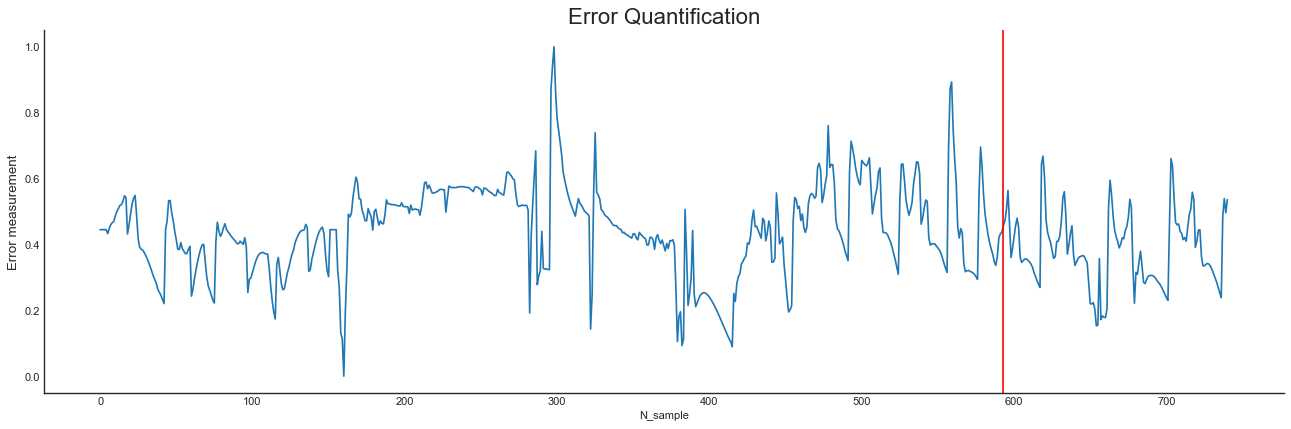

In [19]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(np.concatenate([yt,ye]))
plt.title('Error Quantification', fontsize = 20)
plt.xlabel('N_sample')
plt.ylabel('Error measurement', fontsize = 12)
plt.axvline(x=train_index,color = 'r')

ny = 15
nu = 15 # model orders
(Ye,Phie) = matReg(ye,ue,ny,nu)
(Yt,Phit) = matReg(yt,ut,ny,nu)

# definicao da arquitetura
_ , ninp = Phie.shape
nout = 1
nneu = 70 # how many neurons per layer

# multiple runs setup
nsim = 3
now = datetime.now()
uniqueStr = now.strftime("test_%Y%m%d_%Hh%Mm%Ss")
mkdir(uniqueStr)
MATR2 = np.zeros((nsim,4)) # 4: 4 tipos de R2

In [20]:
t0= time.perf_counter()
for k in range(nsim):
    # model definition
    input_ = keras.layers.Input(shape=(ninp,))
    hidden1 = keras.layers.Dense(nneu, activation="tanh",kernel_initializer="GlorotNormal",)(input_)
    hidden2 = keras.layers.Dense(nneu, activation="tanh",kernel_initializer="GlorotNormal")(hidden1)
    dropout1 = keras.layers.Dropout(0.2)(hidden2)
    hidden3 = keras.layers.Dense(nneu, activation="tanh",kernel_initializer="GlorotNormal")(dropout1)
    dropout2 = keras.layers.Dropout(0.2)(hidden3)
    output = keras.layers.Dense(nout)(dropout2)

    # instantiate model
    model = keras.models.Model(inputs=[input_],outputs=[output])

    # define optimizer and learning rate
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
    
    #Define EarlyStopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=16)

    # compile model to train it
    model.compile(loss="mean_squared_error", optimizer=optimizer)

    # history = model.fit(Phie, Ye, epochs=10, batch_size = 8)
    history = model.fit(Phie, Ye, epochs=128, batch_size = 32, validation_split=0.15, callbacks=[callback])

    # One step ahead
    y_train_pred1 = model.predict(Phie)
    y_test_pred1  = model.predict(Phit)
    R2test1  = r2_score(Yt, y_test_pred1)
    R2train1 = r2_score(Ye, y_train_pred1)

    # Free Run
    y_train_pred0 = freeRun(model,ye,ue,ny,nu)
    y_test_pred0  = freeRun(model,yt,ut,ny,nu)
    R2train0 = r2_score(Ye, y_train_pred0)
    R2test0  = r2_score(Yt, y_test_pred0)

    print('-------------- One step ahead  --------------')
    print('R2test1  =')
    print(R2test1)
    print('R2train1  =')
    print(R2train1)

    print('-------------- Free Run  --------------')
    print('R2test0  =')
    print(R2test0)
    print('R2train0  =')
    print(R2train0)
    # b = [0, -1, 3, 8, 9]
    # plt.figure()
    # plt.plot(b,'k')
    # plt.savefig("plot_1_test_%1d.png" %(k))
    # plt.show()
    # plt.close()

    # plots (time)
    # ESTIMATION 
    plt.figure()
    plt.subplot(211)
    plt.plot(Ye,'k',y_train_pred1,'r')
    plt.title('OSA')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.subplot(212)
    plt.plot(Ye,'k',y_train_pred0,'r')
    plt.title('FR')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.savefig(uniqueStr + "/test_%1d_plot_1.png" %(k))
    # plt.show()
    plt.close()
    
    # VALIDATION 
    plt.figure()
    plt.subplot(211)
    plt.plot(Yt,'k',y_test_pred1,'r')
    plt.title('OSA')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.subplot(212)
    plt.plot(Yt,'k',y_test_pred0,'r')
    plt.title('FR')
    plt.legend(('real','prediction'))
    plt.grid()
    plt.savefig(uniqueStr + "/test_%1d_plot_2.png" %(k))
    # plt.show()
    plt.close()

    plt.figure()
    minY = min(min(Ye),min(y_train_pred0))
    maxY = max(max(Ye),max(y_train_pred0))
    plt.subplot(1,2,1)
    plt.scatter(Ye,y_train_pred0,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Estimation FR')
    plt.grid()
    plt.legend()

    minY = min(min(Ye),min(y_train_pred1))
    maxY = max(max(Ye),max(y_train_pred1))
    plt.subplot(1,2,2)
    plt.scatter(Ye,y_train_pred1,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Estimation OSA')
    plt.grid()
    plt.legend()
    plt.savefig(uniqueStr + "/test_%1d_plot_3.png" %(k))
    # plt.show()
    plt.close()

    plt.figure()
    minY = min(min(Yt),min(y_test_pred1))
    maxY = max(max(Yt),max(y_test_pred1))
    plt.subplot(1,2,1)
    plt.scatter(Yt,y_test_pred1,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Validation OSA')
    plt.grid()
    plt.legend()
    
    minY = min(min(Yt),min(y_test_pred0))
    maxY = max(max(Yt),max(y_test_pred0))
    plt.subplot(1,2,2)
    plt.scatter(Yt,y_test_pred0,c='red',label='Prediction')
    plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
    plt.xlabel('Real')
    plt.ylabel('Prediction Validation FR')
    plt.grid()
    plt.legend()
    plt.savefig(uniqueStr + "/test_%1d_plot_4.png" %(k))
    # plt.show()
    plt.close()

    # save R2 values
    MATR2[k,] = np.array((R2train1,R2train0,R2test1,R2test0))
    
tMin = (time.perf_counter() - t0)/60
np.savetxt(uniqueStr + "/R2_elapsedTime_%1.4fmin.txt" %tMin, MATR2, fmt='%1.6f')

Epoch 1/128
16/16 [==============================] - 1s 11ms/step - loss: 0.0902 - val_loss: 0.0224
Epoch 2/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0413 - val_loss: 0.0138
Epoch 3/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0236 - val_loss: 0.0082
Epoch 4/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.0079
Epoch 5/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0191 - val_loss: 0.0069
Epoch 6/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0064
Epoch 7/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0153 - val_loss: 0.0061
Epoch 8/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0064
Epoch 9/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0063
Epoch 10/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0056
Epoch 11

16/16 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 84/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 85/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 86/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0046
50
100
150
200
250
300
350
400
450
500
550
50
100
150
-------------- One step ahead  --------------
R2test1  =
0.6802842179022806
R2train1  =
0.7614537945095396
-------------- Free Run  --------------
R2test0  =
-0.8696937833664076
R2train0  =
-0.4636867768497328
Epoch 1/128
16/16 [==============================] - 1s 11ms/step - loss: 0.1328 - val_loss: 0.0211
Epoch 2/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0691 - val_loss: 0.0082
Epoch 3/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0078
Epoch 4/128
16/16 [==============================] 

16/16 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 77/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 78/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 79/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 80/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 81/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 82/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 83/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 84/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 85/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 86/128


16/16 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0046
Epoch 44/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 45/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 46/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 47/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 48/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 49/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0047
Epoch 50/128
16/16 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0052
Epoch 51/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0048
Epoch 52/128
16/16 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 53/128
